In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Ảnh huấn luyện Chest X-Ray:


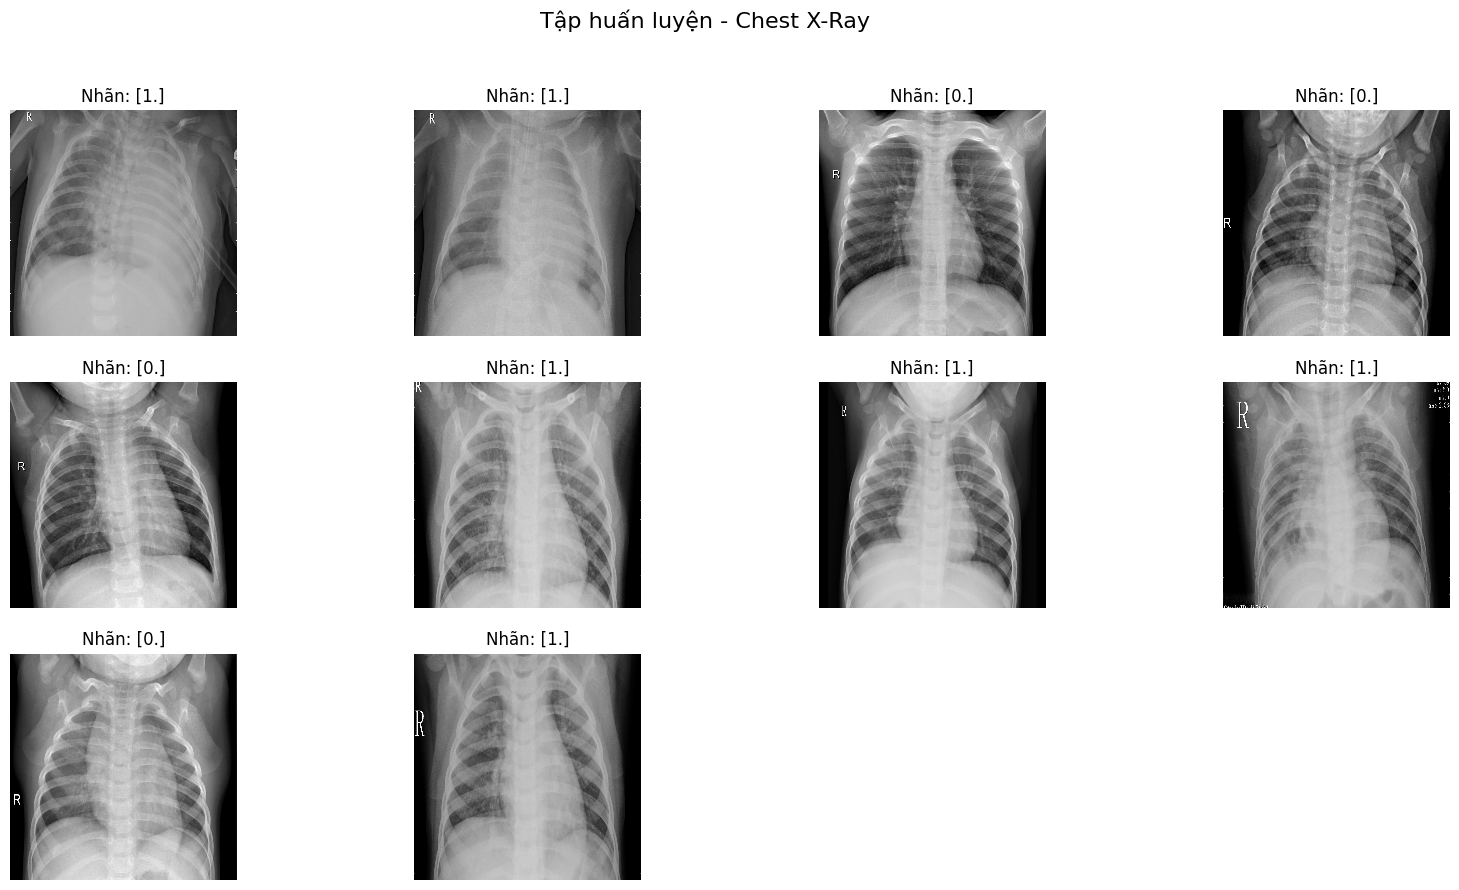


Ảnh kiểm định Chest X-Ray:


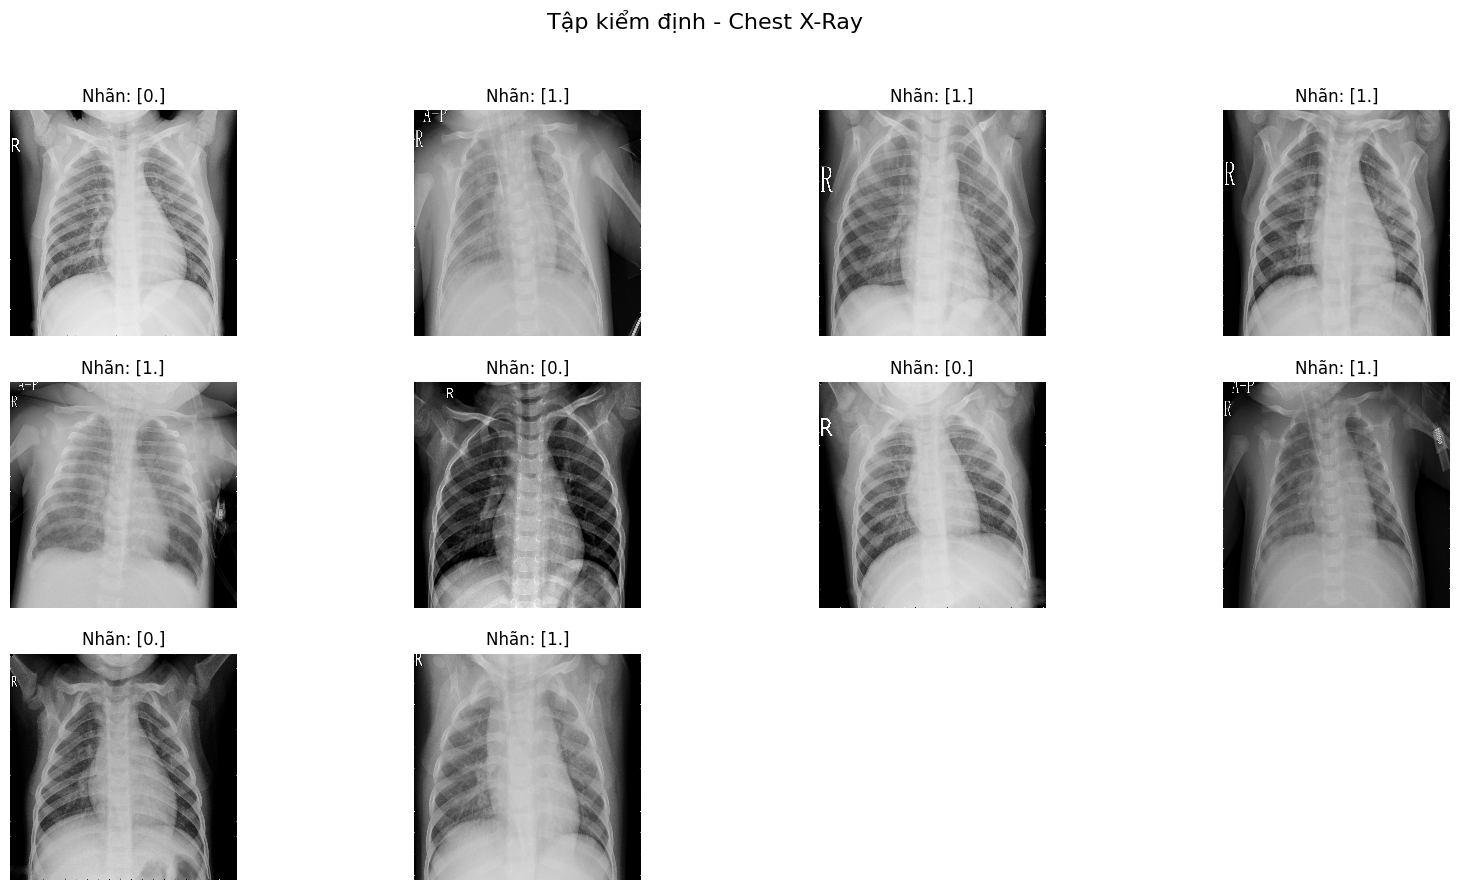


Ảnh kiểm tra Chest X-Ray:


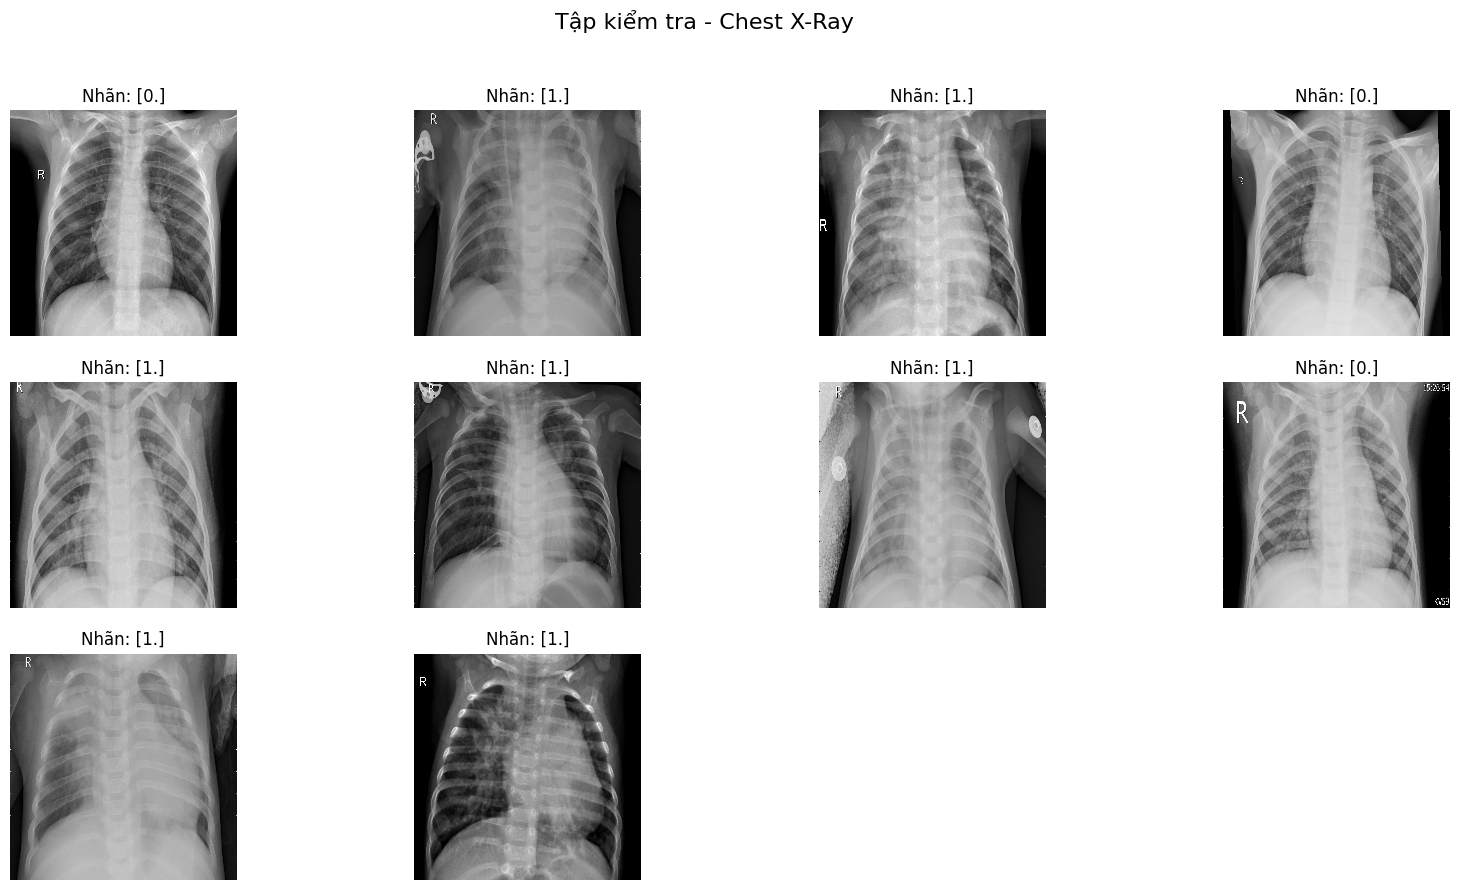

In [2]:
IMG_SIZE = 227
IMG_CHANNEL = 3
BATCH_SIZE = 256
COLOR_MODE = 'rgb'

train_chest = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    labels='inferred',
    label_mode='binary',
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='bilinear'
)

val_chest = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/val',
    labels='inferred',
    label_mode='binary',
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='bilinear'
)

test_chest = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    labels='inferred',
    label_mode='binary',
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation='bilinear'
)

def hien_thi_anh(dataset, so_luong_anh, tieu_de):
    plt.figure(figsize=(20, 10))
    for images, labels in dataset.take(1):
        for i in range(so_luong_anh):
            plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f'Nhãn: {labels[i]}')
            plt.axis('off')
    plt.suptitle(tieu_de, fontsize=16)
    plt.show()

print("Ảnh huấn luyện Chest X-Ray:")
hien_thi_anh(train_chest, 10, "Tập huấn luyện - Chest X-Ray")

print("\nẢnh kiểm định Chest X-Ray:")
hien_thi_anh(val_chest, 10, "Tập kiểm định - Chest X-Ray")

print("\nẢnh kiểm tra Chest X-Ray:")
hien_thi_anh(test_chest, 10, "Tập kiểm tra - Chest X-Ray")

In [4]:
vgg = VGG16(include_top=False, input_shape=(227, 227, 3))
for layer in vgg.layers:
    layer.trainable = False

flat = Flatten()(vgg.layers[-1].output)
fc1 = Dense(1024, activation='relu')(flat)
output = Dense(1, activation='sigmoid')(fc1)
model = Model(inputs=vgg.inputs, outputs=output)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 227, 227, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 227, 227, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 113, 113, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 113, 113, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,406,849 (154.14 MB)

 Trainable params: 25,692,161 (98.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_chest,
    validation_data=val_chest,
    epochs=10,
)

Epoch 1/10


I0000 00:00:1734901108.917679      99 service.cc:145] XLA service 0x7dba7800cea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734901108.917787      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-22 20:58:44.983834: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[256,64,227,227]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,64,227,227]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-22 20:58:45.735004: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.751268579s
T

21/21 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8707 - loss: 9.7737 - val_accuracy: 0.8750 - val_loss: 13.5363
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 749ms/step - accuracy: 0.9846 - loss: 0.9872 - val_accuracy: 1.0000 - val_loss: 2.5611e-14
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 733ms/step - accuracy: 0.9941 - loss: 0.2204 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 751ms/step - accuracy: 0.9980 - loss: 0.0409 - val_accuracy: 0.9375 - val_loss: 0.7356
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 728ms/step - accuracy: 0.9988 - loss: 0.0083 - val_accuracy: 0.8750 - val_loss: 2.1785
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 751ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.8125 - val_loss: 3.9163
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 729ms/step - accuracy: 0.9992 - loss: 0.0107 - val_accuracy: 0.8750 - val_loss: 1.0416
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 751ms/step - accuracy: 1.0000 - loss: 2.9322e-04 - val_accuracy:

In [6]:
model.save('pneumonia_vgg16_bai7.keras')

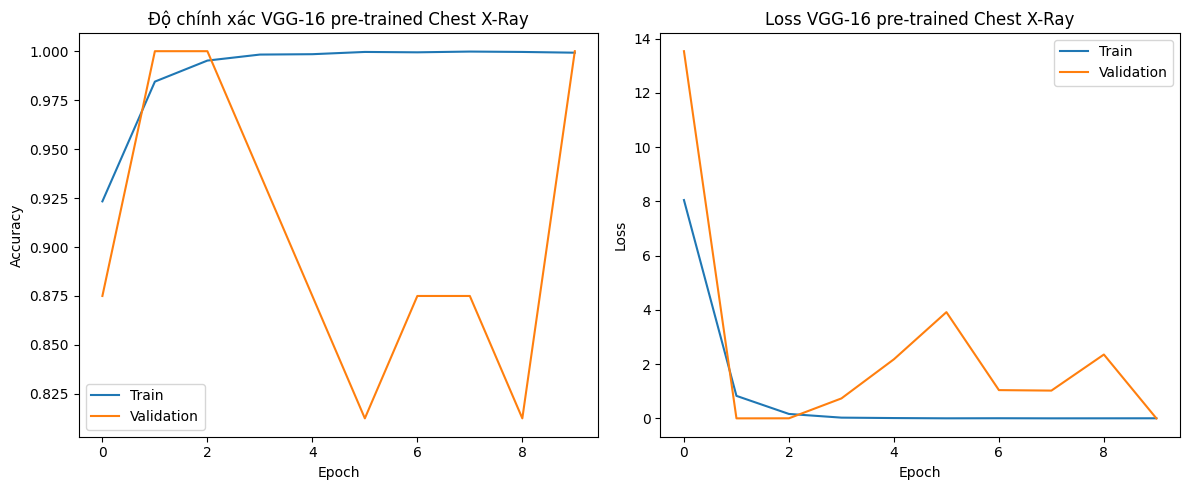

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Độ chính xác VGG-16 pre-trained Chest X-Ray')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss VGG-16 pre-trained Chest X-Ray')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
y_pred_total = []
y_true = []

for img, label in test_chest:
    y_pred = model.predict(img)
    y_pred_total += [1 if i > 0.5 else 0 for i in y_pred]
    y_true += np.array(label).flatten().tolist()

accuracy = accuracy_score(y_true, y_pred_total)
precision = precision_score(y_true, y_pred_total)
recall = recall_score(y_true, y_pred_total)
f1 = f1_score(y_true, y_pred_total)

print(f'Độ chính xác (Accuracy): {accuracy:.4f}')
print(f'Độ chính xác (Precision): {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Điểm F1 (F1-score): {f1:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Độ chính xác (Accuracy): 0.7772
Độ chính xác (Precision): 0.7372
Recall: 1.0000
Điểm F1 (F1-score): 0.8487
